In [17]:
### Generic imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats

### ML imports
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import callbacks
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from livelossplot.keras import PlotLossesCallback

### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Plot setup
plt.rcParams.update({
    'figure.dpi': 150,
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 15,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

Note: To type Greek letters for variables, type e.g. "\alpha" and then hit TAB.

### Load data & preprocess

In [4]:
file = "/data0/mpettee/gaia_data/GD1-circle-140-30-15.pkl"
df = np.load(file, allow_pickle = True)

### Select columns
columns = ['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','streammask']
df = df[columns]

### Create b-r & g columns; rename others
df["b-r"] = df.phot_bp_mean_mag - df.phot_rp_mean_mag
df.drop(columns = ['phot_bp_mean_mag','phot_rp_mean_mag'], inplace=True)
df.rename(columns={'phot_g_mean_mag': 'g', 
                   'ra': 'α',
                   'dec': 'δ',
                   'pmra': 'μ_α',
                   'pmdec': 'μ_δ'}, inplace=True)

### Drop any rows containing a NaN value
df.dropna(inplace = True)

### Restrict data to a radius of 15
center_α = 0.5*(df.α.min()+df.α.max())
center_δ = 0.5*(df.δ.min()+df.δ.max())
df = df[np.sqrt((df.δ-center_δ)**2+(df.α-center_α)**2) < 15]

### Construct GD1 DataFrame
gd1 = df[df.streammask == True]

# ### Exclude GD1 from main DataFrame
# df = df[df.streammask == False]

### Visualize the data

First, a plot in angular spatial coordinates, highlighting GD1:

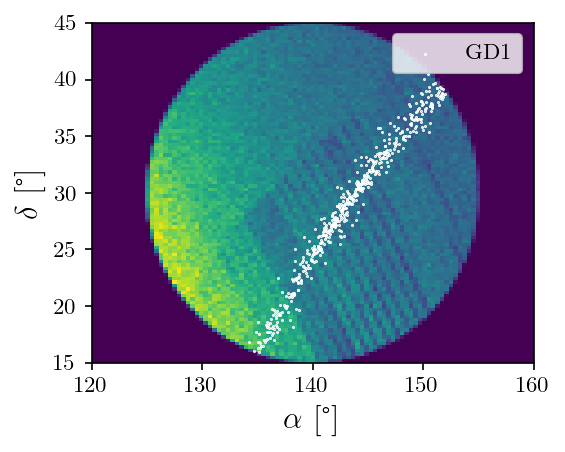

In [77]:
plt.figure(figsize=(3.8,3)) # kind of a squishy circle
plt.hist2d(df.α,df.δ,bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gd1.α,gd1.δ,color='white',s=0.2, label="GD1")
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]")
plt.legend();

Next, the angular velocities for the background:

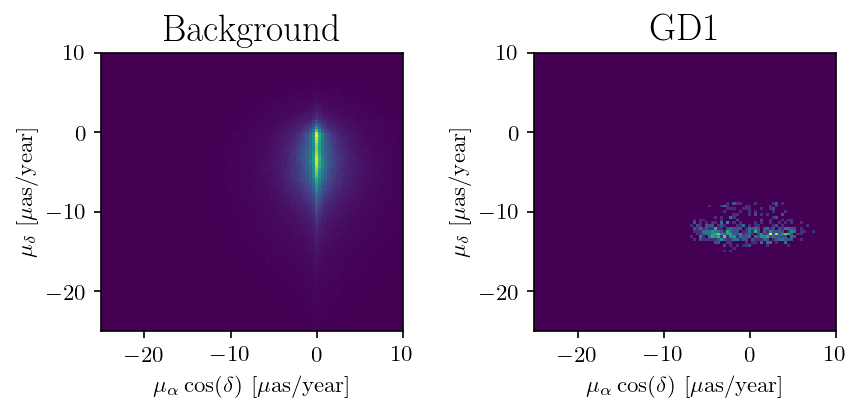

In [7]:
bins = np.linspace(-25,10,100)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3), tight_layout=True)

ax = axs[0]
ax.hist2d(df.μ_α*np.cos(df.δ),df.μ_δ, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("Background")

ax = axs[1]
ax.hist2d(gd1.μ_α*np.cos(gd1.δ),gd1.μ_δ, bins=[bins,bins])
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=11)
ax.set_ylabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=11);
ax.set_title("GD1");

### Define the signal & sideband regions

We want to pick a variable that is relatively localized for GD1. Comparing these two angular velocities, it's clear that we should pick $\mu_\delta$, as its distribution is narrower:

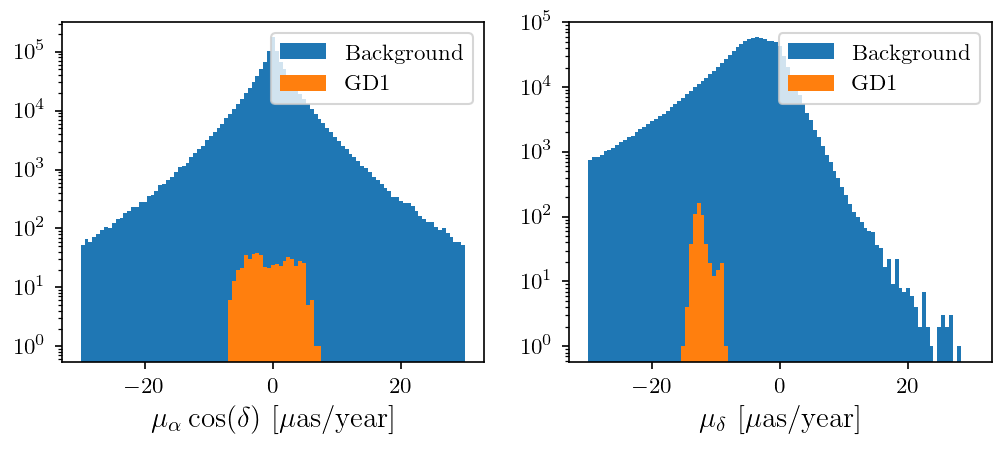

In [8]:
fig, axs = plt.subplots(figsize=(8,3), nrows=1, ncols=2)
ax = axs[0]
ax.hist(df.μ_α*np.cos(df.δ), bins = np.linspace(-30,30,100), label="Background")
ax.hist(gd1.μ_α*np.cos(gd1.δ), bins = np.linspace(-30,30,100), label="GD1")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]", fontsize=14)

ax = axs[1]
ax.hist(df.μ_δ, bins = np.linspace(-30,30,100), label="Background")
ax.hist(gd1.μ_δ, bins = np.linspace(-30,30,100), label="GD1")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel(r"$\mu_\delta$ [$\mu$as/year]", fontsize=14);

Now we'll define the signal & sideband regions for this variable:

In [128]:
df_slice = df[(df.μ_δ > -18) & (df.μ_δ < -9.5) ]
df_slice['label'] = np.where(((df_slice.μ_δ > -15) & (df_slice.μ_δ < -11)), 1, 0)

/tmp/ipykernel_15701/1945792127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > -15) & (df_slice.μ_δ < -11)), 1, 0)


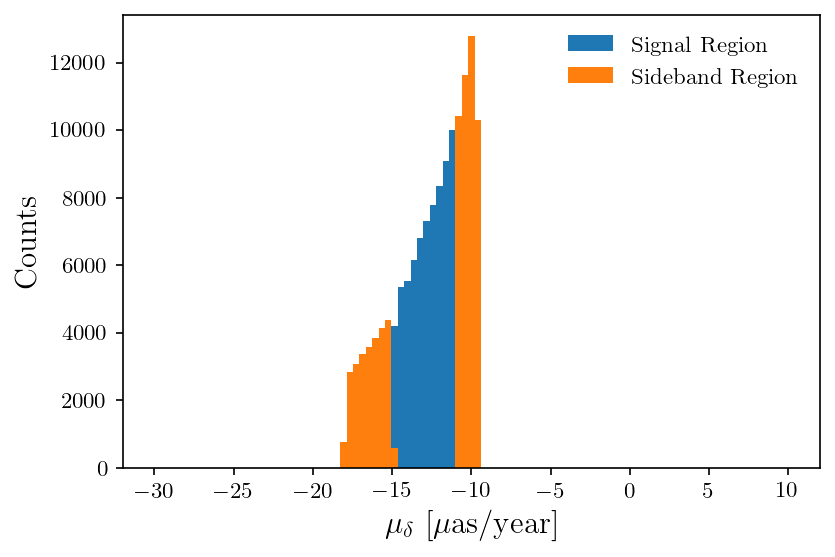

In [129]:
bins = np.linspace(-30,10,100)
plt.hist(df_slice[df_slice.label == 1].μ_δ,bins=bins,label="Signal Region")
plt.hist(df_slice[df_slice.label == 0].μ_δ,bins=bins,label="Sideband Region")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("Counts");

##### Scale and rotate the datasets (why?):

In [35]:
# def rotate(x, y, θ):
#     return (x*np.cos(θ) + y*np.sin(θ), -x*np.sin(θ) + y*np.cos(θ))

In [36]:
# Xr, Yr = rotate(signal.ra-center_ra, signal.dec-center_dec, -0.5)
# Xbr, Ybr = rotate(sideband.ra-center_ra, sideband.dec-center_dec, -0.5)
# Xsr, Ysr = rotate(gd1.ra-center_ra, gd1.dec-center_dec, -0.5)

# signal["x"] = Xr
# sideband["x"] = Xbr
# gd1["x"] = Xsr

### Prepare datasets for training

In [137]:
training_vars = ['α','δ','μ_α','b-r','g'] 

# 70/15/15 train/validate/test split
train, validate, test = np.split(df_slice.sample(frac=1), [int(.7*len(df_slice)), int(.85*len(df_slice))])

x_train, x_val, x_test = [train[training_vars], validate[training_vars], test[training_vars]]
y_train, y_val, y_test = [train.label, validate.label, test.label]

# pre-processing by official method:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

### Train CWoLa model

In [138]:
model = Sequential()
model.add(Dense(64, input_dim=len(training_vars), activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

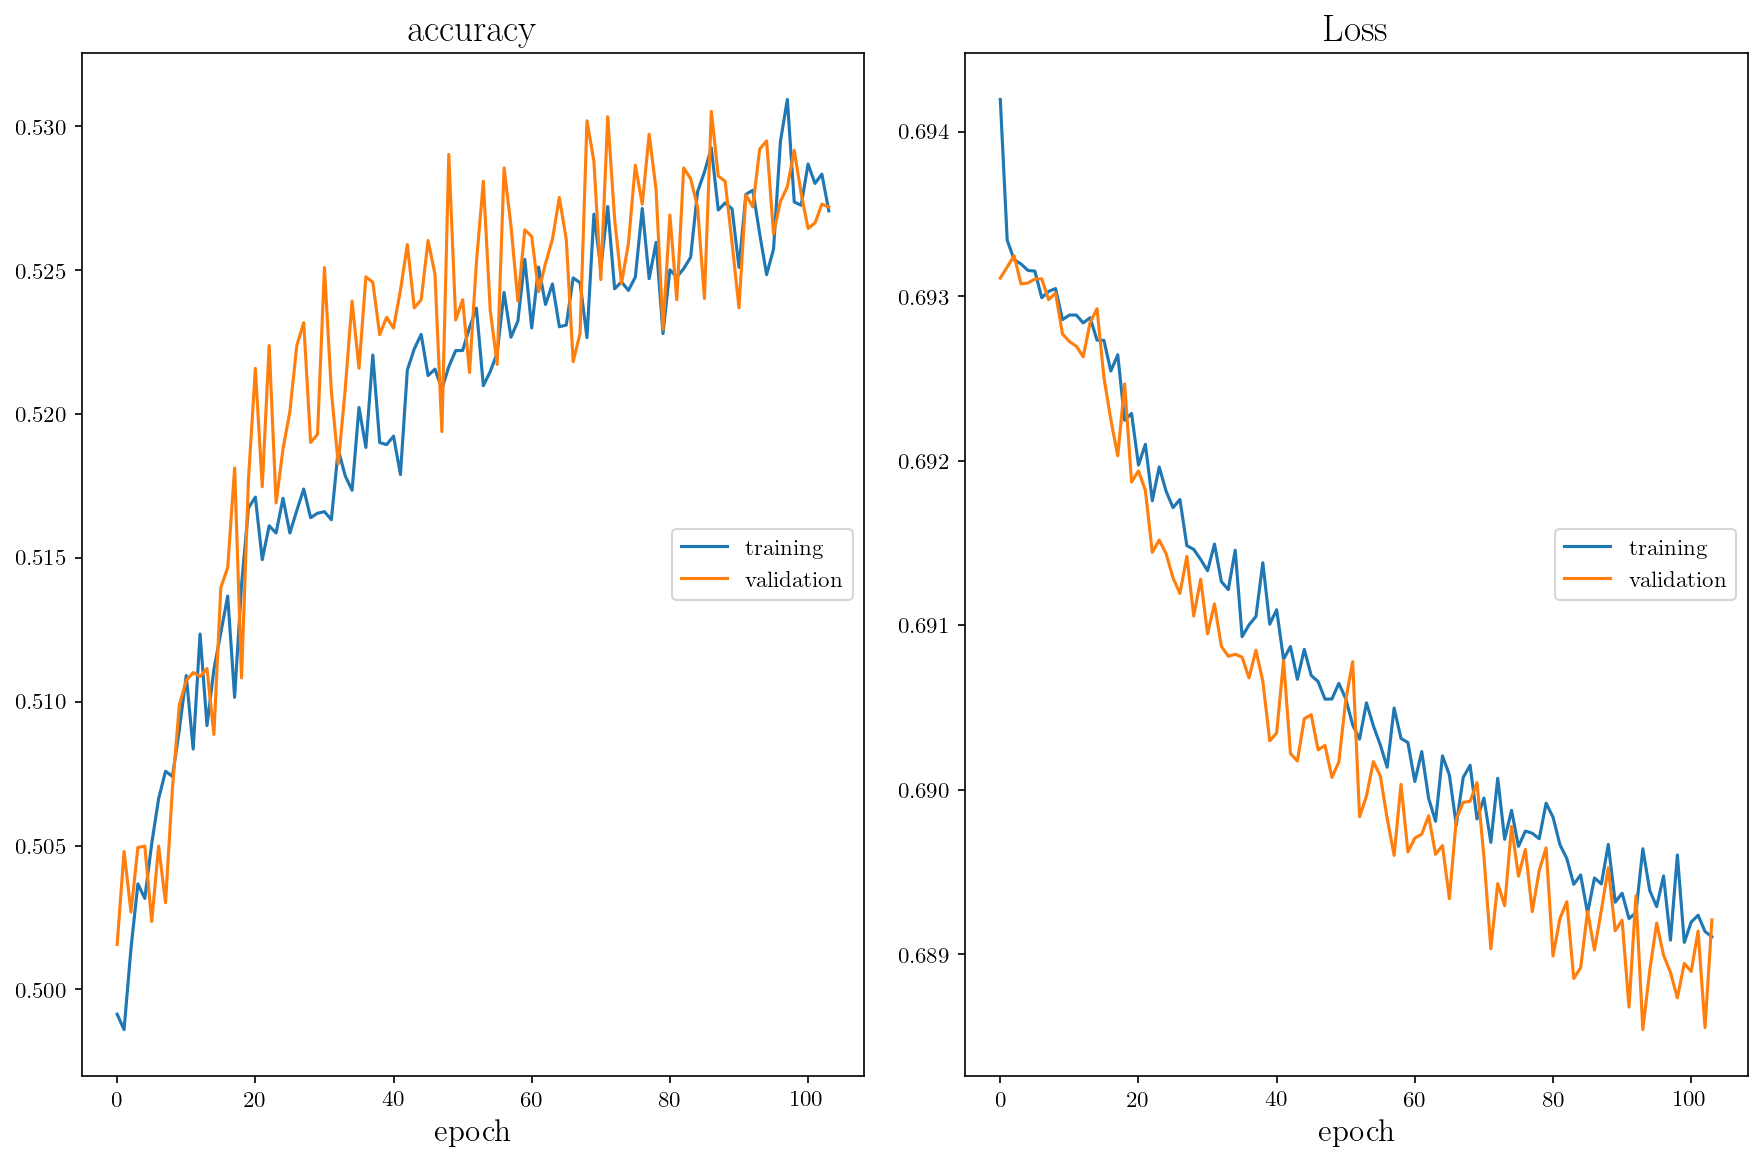

accuracy
	training         	 (min:    0.499, max:    0.531, cur:    0.527)
	validation       	 (min:    0.502, max:    0.531, cur:    0.527)
Loss
	training         	 (min:    0.689, max:    0.694, cur:    0.689)
	validation       	 (min:    0.689, max:    0.693, cur:    0.689)

Epoch 00104: val_loss did not improve from 0.68854
Epoch 00104: early stopping


In [139]:
# stops if val_loss doesn't improve for [patience] straight epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=10, 
                                         verbose=1) 

# saves weights from the epoch with lowest val_loss 
checkpoint = callbacks.ModelCheckpoint("best_weights.h5", 
                                       monitor='val_loss', 
                                       mode='auto', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True)

history = model.fit(X_train, Y_train, 
                    epochs=200, 
                    batch_size=64,
                    validation_data=(x_val,y_val),
                    callbacks = [PlotLossesCallback(),
                                checkpoint, 
                                early_stopping]
                   )

AUC: 0.5385946089679692


Text(0, 0.5, 'Events')

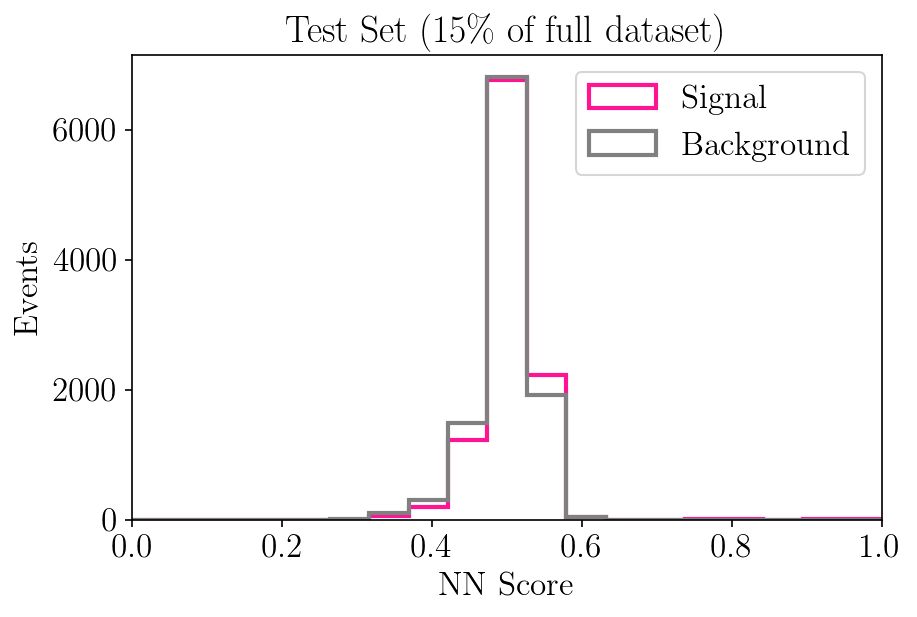

In [143]:
# Load the checkpointed model
model.load_weights("best_weights.h5")

### Add the NN prediction score to the test set: 
test["nn_score"] = model.predict(x_test)
fake_eff_baseline, real_eff_baseline, thresholds = roc_curve(np.asarray(y_test), test.nn_score)
auc_baseline = auc(fake_eff_baseline, real_eff_baseline)
print("AUC: {}".format(auc_baseline))

### Plot scores:
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
bins=np.linspace(0,1,20)

ax.tick_params(labelsize=16)
ax.hist(test[test.label == 1].nn_score, bins=bins, histtype='step', linewidth=2, color="deeppink", label="Signal")
ax.hist(test[test.label == 0].nn_score, bins=bins, histtype='step', linewidth=2, color="grey", label="Background")
ax.legend(fontsize=16)
ax.set_xlim(0, 1)
ax.set_title("Test Set (15\% of full dataset)")
ax.set_xlabel("NN Score", size=16)
ax.set_ylabel("Events", size=16)

### Make plot of highest-ranked stars

Plot top $x\%$ of stars by NN score:

In [238]:
x = 0.4 # desired percentage
top_stars = test[(test['nn_score'] >= test['nn_score'].quantile((100-x)/100))]

How much do these stars overlap with the true GD1 stars?

In [239]:
n_perfect_matches = top_stars.streammask.value_counts()[True]
gd1_stars_in_test_set = test[test.streammask == True]

print("The NN identified {:.1f}% of GD1 stars in the test set.".format(100*n_perfect_matches/len(gd1_stars_in_test_set)))
print("{:.1f}% of top stars identified are real GD1 stars.".format(n_perfect_matches/len(top_stars)*100))

The NN identified 78.2% of GD1 stars in the test set.
70.9% of top stars identified are real GD1 stars.


Plot them:

Text(0, 0.5, '$\\delta$ [\\textdegree]')

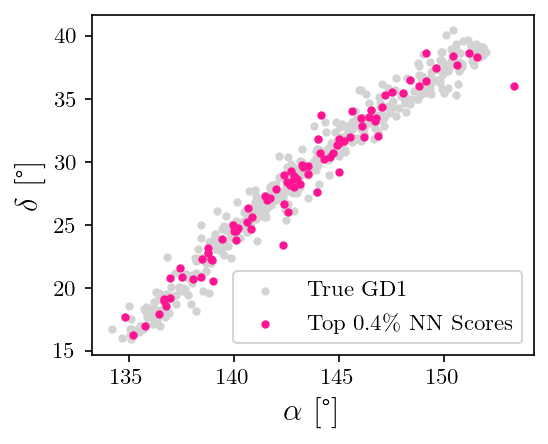

In [243]:
plt.figure(figsize=(3.8,3)) # kind of a squishy circle
plt.scatter(gd1.α, gd1.δ, marker='.', 
            # s = 1.0, 
            # alpha = 0.5,
            color = "lightgray",
            label='True GD1')
plt.scatter(top_stars.α, top_stars.δ, marker='.', 
            # s = 1.0,
            # alpha = 0.5,
            color = "deeppink",
            label='Top {:.1f}\% NN Scores'.format(x))
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]")